# Profile of `maze_dataset` Dumping and Loading

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytest

from maze_dataset.dataset.maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
)
from maze_dataset.generation.generators import GENERATORS_MAP

from maze_dataset.utils import timeit_fancy

## Generate Datasets


In [35]:
cfgs = [MazeDatasetConfig(name="test", grid_n=grid_n, n_mazes=n_mazes, maze_ctor=maze_ctor, maze_ctor_kwargs=maze_ctor_kwargs, serialize_minimal_threshold=srz_threshold) 
        for grid_n, n_mazes, maze_ctor, maze_ctor_kwargs, srz_threshold in [
                (3, 1, GENERATORS_MAP['gen_dfs'], {}, 1), 
                (5, 10, GENERATORS_MAP['gen_dfs'], dict(do_forks=False), None), 
                (10, 100, GENERATORS_MAP['gen_dfs'], {}, None),
                (5, 10, GENERATORS_MAP['gen_dfs'], {}, None), 
                (5, 100, GENERATORS_MAP['gen_dfs'], {}, None), 
                (5, 1000, GENERATORS_MAP['gen_dfs'], {}, None), 
                ]]
datasets = [MazeDataset.generate(cfg) for cfg in cfgs]
old_len_cfgs = len(cfgs)  # Used in section for large dataset profiling

## Profile

In [27]:
columns=['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds = pd.DataFrame(np.zeros([len(cfgs), len(columns)]), columns=columns)
speeds.grid_n = [c.grid_n for c in cfgs]
speeds.n_mazes = [c.n_mazes for c in cfgs]

## Profile small datasets only

In [28]:
for i, d in enumerate(datasets):
    print(f'Profiling: {d.cfg}')
    d.cfg.serialize_minimal_threshold = None
    speeds.loc[i, 'serialize']        , s    = timeit_fancy(d.serialize, get_return=True)
    speeds.loc[i, 'serialize_minimal'], smin = timeit_fancy(d.serialize_minimal, get_return=True)
    speeds.loc[i, 'load']                    = timeit_fancy(lambda: MazeDataset.load(s))
    speeds.loc[i, 'load_minimal']            = timeit_fancy(lambda: MazeDataset.load(smin))
    p = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'.zanj'))
    p_min = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'_min.zanj'))
    speeds.loc[i, 'save']                    = timeit_fancy(lambda: d.save(file_path=p))
    speeds.loc[i, 'read'], rt                = timeit_fancy(lambda: MazeDataset.read(file_path=p), get_return=True)
    d.cfg.serialize_minimal_threshold = 1
    speeds.loc[i, 'save_minimal']            = timeit_fancy(lambda: d.save(file_path=p_min))
    speeds.loc[i, 'read_minimal'], rt_min    = timeit_fancy(lambda: MazeDataset.read(file_path=p_min), get_return=True)
    d.cfg.serialize_minimal_threshold = None
    # rt
    # !rm {p} {p_min}
    

Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=3, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000028854782B00>, maze_ctor_kwargs={}, serialize_minimal_threshold=1)
Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000028854782B00>, maze_ctor_kwargs={'do_forks': False}, serialize_minimal_threshold=None)
Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=100, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000028854782B00>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000028854782B00>, maze_ctor_kwargs={}, ser

### Results

In [29]:
max_ind, max_n = np.argmax(speeds.n_mazes.values), np.max(speeds.n_mazes.values)
print(f'{max_n} mazes:')
for c_i in range(2, 10, 2):
    advantage = speeds.iloc[max_ind, c_i] / speeds.iloc[max_ind, c_i+1]
    print('`{}`: \tminimal/standard speedup: {:4.1f}x'.format(speeds.columns[c_i], advantage))

1000 mazes:
`serialize`: 	minimal/standard speedup:  0.1x
`load`: 	minimal/standard speedup:  7.1x
`save`: 	minimal/standard speedup:  2.1x
`read`: 	minimal/standard speedup: 29.3x


In [30]:
speeds

,grid_n,n_mazes,serialize,serialize_minimal,load,load_minimal,save,save_minimal,read,read_minimal
0,3,1,0.007366,0.022888,0.018409,0.020015,0.095492,0.109092,0.021837,0.022171
1,5,10,0.007465,0.027584,0.024066,0.020911,0.135752,0.117890,0.033987,0.023658
2,10,100,0.009145,0.062762,0.066691,0.024426,0.897060,0.164078,0.829556,0.031067
3,5,10,0.007626,0.027740,0.023294,0.020738,0.126897,0.114697,0.044599,0.024754
4,5,100,0.009075,0.057039,0.067310,0.024252,0.369746,0.146264,0.254677,0.026847
5,5,1000,0.024118,0.349135,0.507693,0.071371,1.027326,0.499295,2.319588,0.079032


Text(0, 0.5, 'Runtime [sec]')

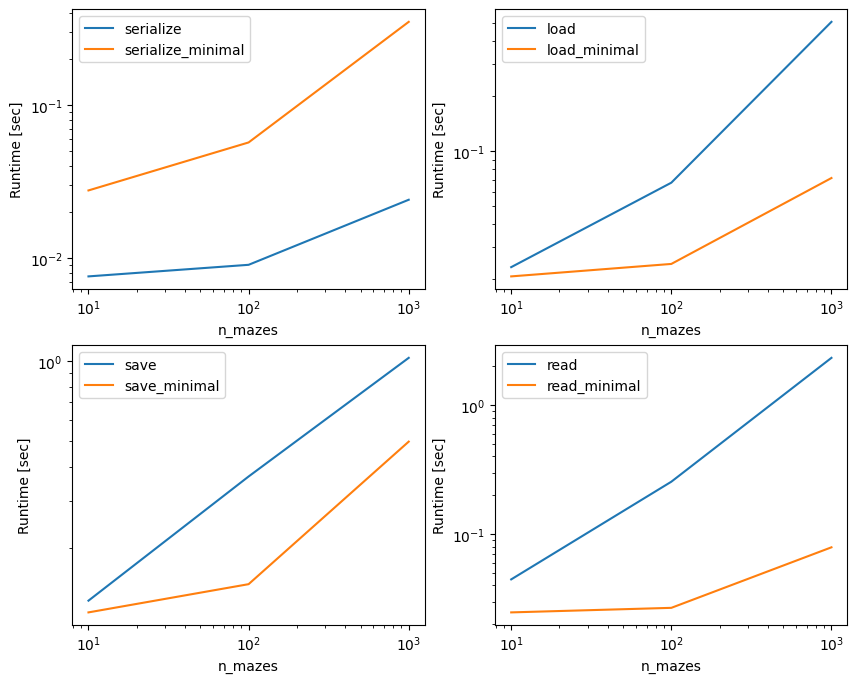

In [31]:
fig = plt.figure(figsize=(10,8))
fig.subplots(2,2)
ax = fig.axes[0]
speeds.loc[3:, ['n_mazes', 'serialize', 'serialize_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[1]
speeds.loc[3:, ['n_mazes', 'load', 'load_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[2]
speeds.loc[3:, ['n_mazes', 'save', 'save_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[3]
speeds.loc[3:, ['n_mazes', 'read', 'read_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

## Profile Large Datasets
This section should be skipped during the CI autoruns since running timing on large datasets takes awhile. `exit` is called so that execution stops and the cell outputs below are preserved. The outputs are for reference and manual rerun after further updates to `serialize`, `load`, `save`, etc. To manually rerun with all the datasets, just comment out the cell below first. Run, then uncomment it again before merging.

In [32]:
import sys
sys.exit(0)

SystemExit: 0

c:\Users\Aaron\AppData\Local\pypoetry\Cache\virtualenvs\maze-dataset-zQQMZP3O-py3.10\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [36]:
cfgs.extend(
    [MazeDatasetConfig(name="test", grid_n=grid_n, n_mazes=n_mazes, maze_ctor=maze_ctor, maze_ctor_kwargs=maze_ctor_kwargs, serialize_minimal_threshold=srz_threshold) 
        for grid_n, n_mazes, maze_ctor, maze_ctor_kwargs, srz_threshold in [
            (5, 10000, GENERATORS_MAP['gen_dfs'], {}, None), 
        ]
    ]
)
datasets.extend([MazeDataset.generate(cfg) for cfg in cfgs[old_len_cfgs:]])

In [37]:
for i, d in enumerate(datasets):
    if i < old_len_cfgs: continue  # No need to rerun small datasets
    print(d.cfg)
    d.cfg.serialize_minimal_threshold = None
    speeds.loc[i, 'serialize']        , s    = timeit_fancy(d.serialize, get_return=True)
    speeds.loc[i, 'serialize_minimal'], smin = timeit_fancy(d.serialize_minimal, get_return=True)
    speeds.loc[i, 'load']                    = timeit_fancy(lambda: MazeDataset.load(s))
    speeds.loc[i, 'load_minimal']            = timeit_fancy(lambda: MazeDataset.load(smin))
    p = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'.zanj'))
    p_min = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'_min.zanj'))
    speeds.loc[i, 'save']                    = timeit_fancy(lambda: d.save(file_path=p))
    speeds.loc[i, 'read'], rt                = timeit_fancy(lambda: MazeDataset.read(file_path=p), get_return=True)
    d.cfg.serialize_minimal_threshold = 1
    speeds.loc[i, 'save_minimal']            = timeit_fancy(lambda: d.save(file_path=p_min))
    speeds.loc[i, 'read_minimal'], rt_min    = timeit_fancy(lambda: MazeDataset.read(file_path=p_min), get_return=True)
    d.cfg.serialize_minimal_threshold = None    

MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=10000, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000028854782B00>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)


In [41]:
speeds.grid_n = [c.grid_n for c in cfgs]
speeds.n_mazes = [c.n_mazes for c in cfgs]

### Results

In [42]:
max_ind, max_n = np.argmax(speeds.n_mazes.values), np.max(speeds.n_mazes.values)
print(f'{max_n} mazes:')
for c_i in range(2, 10, 2):
    advantage = speeds.iloc[max_ind, c_i] / speeds.iloc[max_ind, c_i+1]
    print('`{}`: \tminimal/standard speedup: {:3.1f}x'.format(speeds.columns[c_i], advantage))

10000 mazes:
`serialize`: 	minimal/standard speedup: 0.0x
`load`: 	minimal/standard speedup: 8.3x
`save`: 	minimal/standard speedup: 2.6x
`read`: 	minimal/standard speedup: 38.1x


In [43]:
speeds

,grid_n,n_mazes,serialize,serialize_minimal,load,load_minimal,save,save_minimal,read,read_minimal
0,3,1,0.007366,0.022888,0.018409,0.020015,0.095492,0.109092,0.021837,0.022171
1,5,10,0.007465,0.027584,0.024066,0.020911,0.135752,0.117890,0.033987,0.023658
2,10,100,0.009145,0.062762,0.066691,0.024426,0.897060,0.164078,0.829556,0.031067
3,5,10,0.007626,0.027740,0.023294,0.020738,0.126897,0.114697,0.044599,0.024754
4,5,100,0.009075,0.057039,0.067310,0.024252,0.369746,0.146264,0.254677,0.026847
5,5,1000,0.024118,0.349135,0.507693,0.071371,1.027326,0.499295,2.319588,0.079032
6,5,10000,0.168170,3.411988,4.704787,0.570261,9.580028,3.694944,22.799575,0.598477


Comparing rows 2 and 4, it appears that the `grid_n` has a relatively small effect on `serialize` and `load` runtimes. Those functions appear to run in $O(n_{\mathrm{mazes}})$ time. `grid_n` does impact `save` and `read`, but not their `_minimal` counterparts as much.

To compare the speed of analogous procedures vs `n_mazes`, the plots below show data from `speeds.loc[2:5,:]`.

Text(0, 0.5, 'Runtime [sec]')

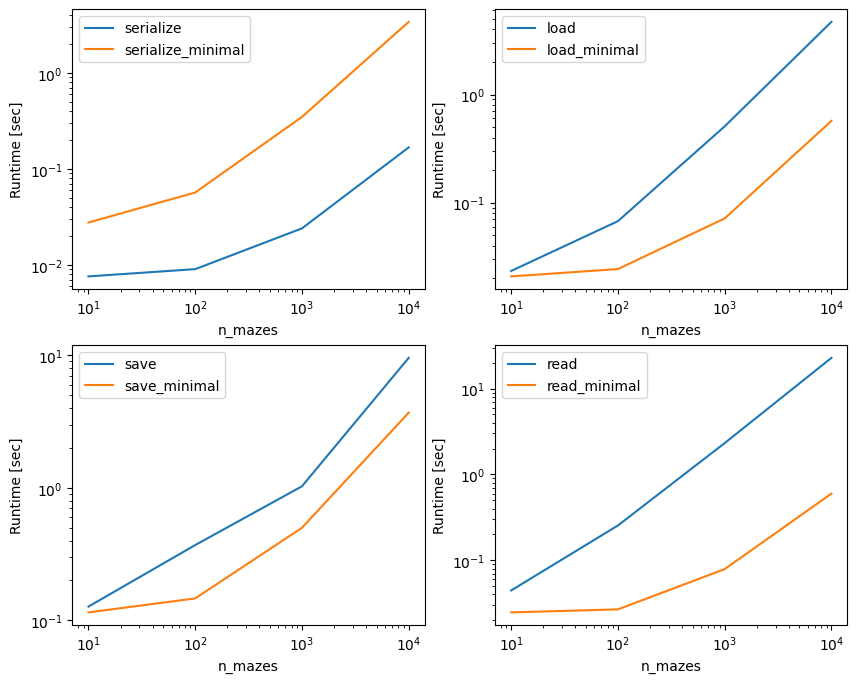

In [44]:
fig = plt.figure(figsize=(10,8))
fig.subplots(2,2)
ax = fig.axes[0]
speeds.loc[3:, ['n_mazes', 'serialize', 'serialize_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[1]
speeds.loc[3:, ['n_mazes', 'load', 'load_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[2]
speeds.loc[3:, ['n_mazes', 'save', 'save_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[3]
speeds.loc[3:, ['n_mazes', 'read', 'read_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')